# Prediction Confidence for Random Forest Model

### Background

The random forest model is know as an easy to implement model that performs well on most datasets.  Random forests can be used to generate predictions for regression and classification problems.  A potential drawback to using a random forest is that there are no built in prediction interval functions to help end users understand how solid an individual prediction is.

There are many examples where a person might want to know how reliable a prediction is.  For example, a hospital may use machine learning to predict the number of emergency room visits or admissions in the coming week for scheduling purposes.  If a prediction from a random forest model shows volume will drop by half next week it would be a good idea to understand that prediction more before cancelling any scheduled help.  Another example might be a car dealer preparing to increase their order volume due to sales predictions showing an increase.  Placing a larger order when it is not needed may lead to an overstock of vehicles and excessive carrying costs.

Rather than sacrafice accuracy and move to a simpler model it would be nice to be able to add a prediction confidence measure to the random forest predictions.

### Objective

The final prediction generated by a random forest model is created using the average prediction from multiple decision trees.  Each decision tree is created using a different sample of records as well as a different sample of columns at each node.  The random sampling of records and columns allows each decision tree to have a unique set of criteria used to create a prediction.  

This walkthrough will demonstrate how to use the different predictions generated by the individual decision trees within a random forest model to determine a level of confidence within the prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
np.set_printoptions(linewidth=100)

### For this demonstration we will use the Auto MPG Data Set from the UCI Machine Learning Repository

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/'
names = ['mpg','cylinders','displacement','horsepower','weight','acceleration','model year','origin','car name'] 
df = pd.read_fwf(f'{url}auto-mpg.data', names=names, na_values='?')

Our target will be mpg.  We will use all of the features except car name.

In [3]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""


In [4]:
df.shape

(398, 9)

In [5]:
#remove missing values
df.dropna(inplace=True)

In [6]:
#6 records were dropped
df.shape
#i'm excluding model name for simplicity
df.drop('car name', axis=1, inplace=True)

## Create train / test split

In [7]:
df.sample(frac=1, random_state=123).reset_index(drop=True)
train_idx = df[:250]
test_idx = df[250:]

In [8]:
X_train, y_train = train_idx.iloc[:,1:], train_idx['mpg']
X_test, y_test = test_idx.iloc[:,1:], test_idx['mpg']

## Fit random forest model

This is a simple random forest model that will run fast and allow us to see how the random decision trees are working.

In [9]:
rf = RandomForestRegressor(n_estimators=10, max_features =.4, max_depth = 3, random_state=123)
rf.fit(X_train, y_train)

# check scores to make sure we have a decent model.  Not going to focus on accuracy for this exercise.
#print("OOB Score:", rf.oob_score_)
print("Test Score:", rf.score(X_test, y_test))

Test Score: 0.458566215707


## Review a couple of the decision trees

Let's look at a couple of the decision trees created by the random forest model to see how they differ.  The max depth was set to 3 so keep the images readable.

In [10]:
from sklearn.tree import export_graphviz
import pydot
export_graphviz(rf.estimators_[0],
                out_file='tree1.dot',
                rounded=True,
                rotate=True,
                feature_names = X_train.columns)
(graph,) = pydot.graph_from_dot_file('tree1.dot')
graph.write_png('tree1.png')

In [11]:
from sklearn.tree import export_graphviz
import pydot
export_graphviz(rf.estimators_[1],
                out_file='tree2.dot',
                rounded=True,
                rotate=True,
                feature_names = X_train.columns)
(graph,) = pydot.graph_from_dot_file('tree2.dot')
graph.write_png('tree2.png')

### Tree 1
The most important feature is displacement.  Weight and model year are the next most important variables, which both provided significant decreases in MSE.

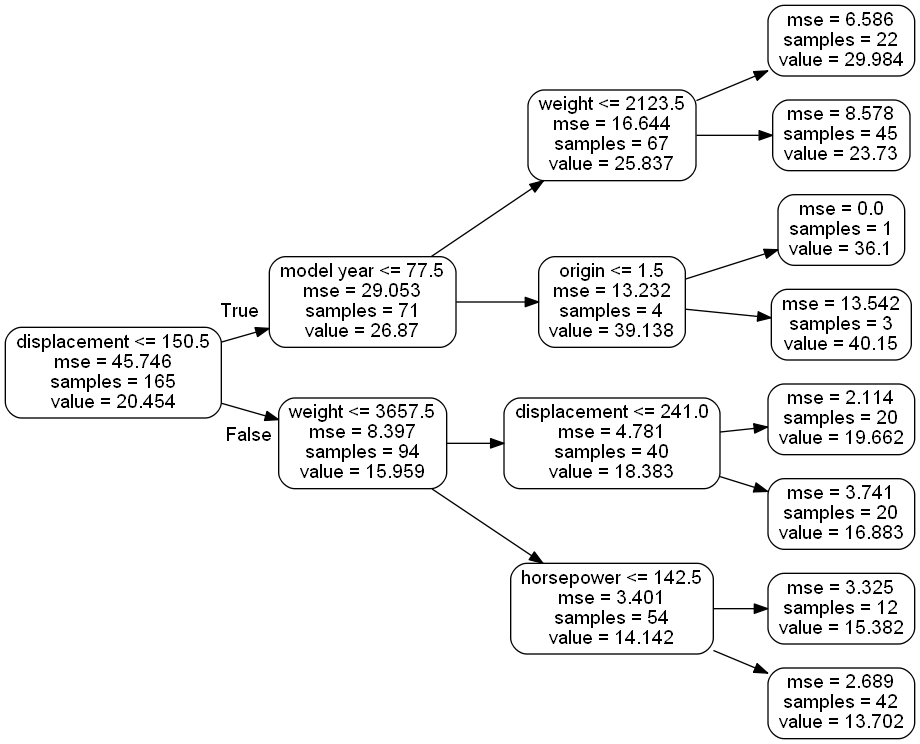

In [12]:
from IPython.display import Image
Image("tree1.png", width=550)

### Tree 2
Cylinders is the most important variable.  Displacement is not even mentioned.  The new sample of records causes the decision tree to grow differently (i.e. different features, thresholds, order of splits, etc).

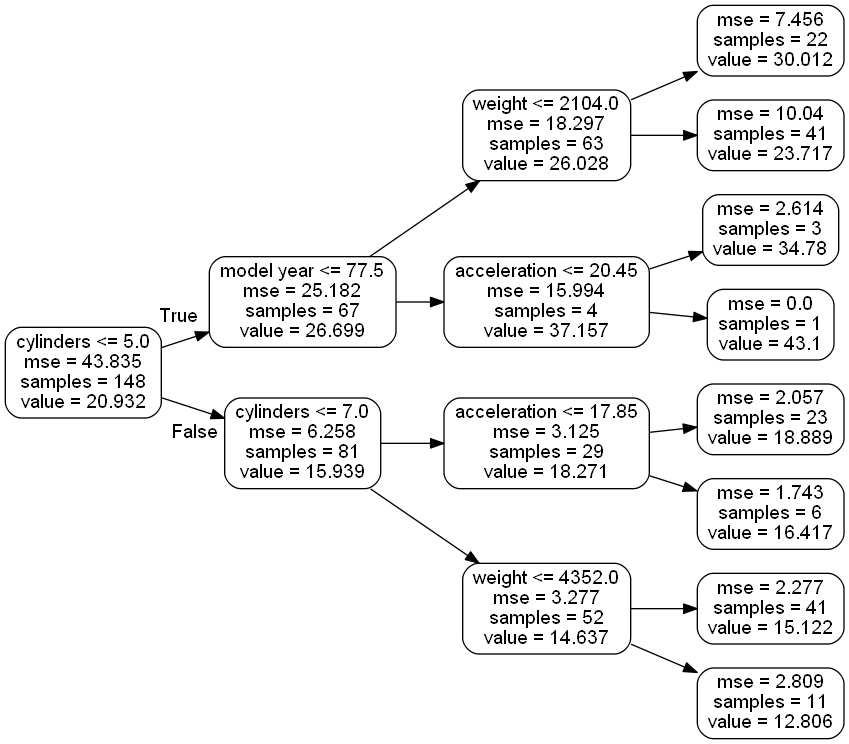

In [13]:
from IPython.display import Image
Image("tree2.png", width=550)

We have seen that our random forest creates unique decision trees because of the different samples of data used in each iteration as well as the different features tested at each split.  Now let's create a prediction confidence value.

## Prediction Confidence

To calculate a confidence measure we are going to use the individual predictions from each decision tree to calculate min, max, and standard deviation for each record in the test set.  Keep in mind, we created 10 decision trees for this example so the n is fairly small.

In [14]:
%time preds = np.stack(np.round([t.predict(X_test) for t in rf.estimators_], decimals=2))

Wall time: 17.2 ms


We have 10 rows of predictions and 142 columns.  One column for each record in the test set.

In [15]:
preds.shape

(10, 142)

Below are the individual predictions from each decision tree for the first record in the test set.

In [16]:
preds[:, 0]

array([ 19.66,  16.42,  18.86,  16.83,  18.43,  20.3 ,  17.1 ,  18.46,  18.  ,  18.05])

Using this individual predictions we calculate our metrics.

In [17]:
np.min(preds[:,0]), np.max(preds[:,0]), np.mean(preds[:,0]), np.std(preds[:,0])

(16.420000000000002,
 20.300000000000001,
 18.211000000000002,
 1.1582007597994399)

### Create a table with prediction metrics

In [18]:
pred_agg = []
count=0
while count < len(preds.T):
    pred_agg.append([np.min(preds[:,count]), np.max(preds[:,count]), np.mean(preds[:,count]), np.std(preds[:,count])])
    count = count + 1

In [19]:
pred_agg[:2]

[[16.420000000000002,
  20.300000000000001,
  18.211000000000002,
  1.1582007597994399],
 [16.420000000000002,
  23.140000000000001,
  18.639000000000003,
  1.8829840679092322]]

Now we just need to combine the new metrics with the test set and review.

In [20]:
#put prediction metrics into dataframe
pred_agg_df = pd.DataFrame(pred_agg, columns=['pred_min','pred_max','actual_pred','pred_std'])

#drop index from test set and put into new variable
test_results = test_idx.reset_index(drop=True)

#combine test set with prediction metrics
test_results = pd.merge(test_results, pred_agg_df, right_index=True, left_index=True)

#calculate prediction error
test_results['error'] = test_results.actual_pred - test_results.mpg
test_results['abs_error'] = abs(test_results.error)

### review the final results

In [21]:
test_results.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,pred_min,pred_max,actual_pred,pred_std,error,abs_error
0,19.2,6,231.0,105.0,3535.0,19.2,78,1,16.42,20.30,18.211,1.158201,-0.989,0.989
1,20.5,6,200.0,95.0,3155.0,18.2,78,1,16.42,23.14,18.639,1.882984,-1.861,1.861
2,20.2,6,200.0,85.0,2965.0,15.8,78,1,18.05,23.62,20.371,1.847590,0.171,0.171
3,25.1,4,140.0,88.0,2720.0,15.4,78,1,20.30,36.10,25.674,5.093718,0.574,0.574
4,20.5,6,225.0,100.0,3430.0,17.2,78,1,17.10,20.30,18.701,0.863707,-1.799,1.799


You can quickly see how the predictions vary in confidence.  The first row has a prediction of 18.2 with a standard deviation of 1.2.  The actual MPG is 19.2.  That looks pretty good.

The fourth row has a prediction of 25.7 with a standard deviation of 5.  Although the prediction happens to be very close, the individual predictions from the decision trees within the random forest had a lot of variation.  This could mean there were not enough cars like this test example in the training set for the decision trees to learn how to deal with them consistently.  Another reason for the variation could be that we created a simple model to use for visualizing the decision trees.  Perhaps tuning the model would reduce the variation between trees for this example.

Reviewing the correlation between prediction standard deviation and absolute error helps us see how well this works.

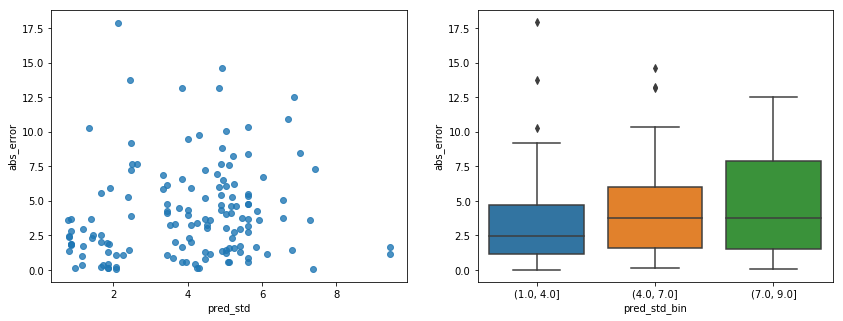

In [22]:
import seaborn as sns

bins = pd.cut(test_results.pred_std, 3, precision=0, right=True)
bins = pd.DataFrame(bins)
bin_df = pd.merge(test_results, bins, left_index=True, right_index=True, suffixes=('','_bin'))

fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))
sns.regplot('pred_std', 'abs_error', test_results, fit_reg=False, ax=ax1)
sns.boxplot(bin_df.pred_std_bin, bin_df.abs_error, ax=ax2)

As the standard deviation increases so does the spread of the errors.  This can be harder to see when looking at the scatterplot, but the boxplot makes it easy to see that as the standard deviation of individual tree predictions increases so does the variation in our error. 